# Facebook Topic Modeling
    Break down posts into sentences

# Instructions to run this Notebook

This Notebook was created in a Python 3.6 environment.

All the libraries are installed with pip. When the code fails to run, just google how to install the missing library. 

The only special case is the spacy library. You need to run the command window as Administrator and then run pip. 
If you still get this error:
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.
You need to run this as Adminnistrator
 python -m spacy link en_core_web_sm en

The dataset used in this Notebook can be downloaded from Teams folder "5-Data Analytics and Results"

I glued together code from several places, but the bulk of the code came from here:
https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm


# Parameters to run this Notebook

In [1]:
input_file_name = "Step1_Shape_Raw_Data.xlsx"
#input_sheet_name = "Twitter_Clean"
input_sheet_name = "Facebook_Clean"
#input_sheet_name = "Combined_Clean"




Fix error in 
nlp = spacy.load('en')
OSError: [E050] Can't find model 'en'. It doesn't seem to be a shortcut link, a Python package or a valid path to a data directory.


Run as Administrator: python -m spacy link en_core_web_sm en
    

In [2]:
import base64
import numpy as np
import pandas as pd
#pd.set_option('display.max_colwidth', None)
pd.set_option('display.width', 100000) # Extend the display width to prevent split functions to not cover full text

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Plotly imports
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

# Other imports
from collections import Counter
#from scipy.misc import imread  deprecated. Import imread from imageio instead

from imageio import imread

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style 
%matplotlib inline


# Libraries for gensim and spacy
import json
import glob
from tqdm.notebook import tqdm
from textblob import TextBlob

import spacy # Leading library for NLP
nlp = spacy.load('en')

import re
import string

import gensim
from gensim import matutils, models
import scipy.sparse

from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer
from nltk.stem.porter import *
import nltk

#from sklearn.feature_extraction.text import CountVectorizer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
#import matplotlib.pyplot as plt



# 1. Load and Inspect the Dataset

In [3]:
# Loading in the Social Media Postsdata with Pandas

dfInput = pd.read_excel(input_file_name, sheet_name=input_sheet_name)

In [4]:
dfInput.head(10)

,Source,Date,Text,Shares,Likes,Comments
0,1,2020-02-01,update on the 2019 novel coronavirus (ncov) - ...,52,54,4.0
1,1,2020-02-01,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14.0
2,1,2020-02-02,as of 2 february 2020 2pm we have not been not...,118,311,32.0
3,1,2020-02-03,minister for health gan kim yong delivered a m...,40,85,25.0
4,1,2020-02-03,as of 3 february 2020 2pm we have not been not...,54,185,13.0
5,1,2020-02-04,as of 4 february 2020 2pm we have confirmed si...,131,276,154.0
6,1,2020-02-04,as of 4 february 12pm 289 of the suspect cases...,42,88,19.0
7,1,2020-02-05,from temperature screenings at changi airport ...,15,73,22.0
8,1,2020-02-05,the straits times spoke to experts in singapor...,58,85,54.0
9,1,2020-02-06,“we are cleaning the escalator hand rails lift...,36,341,23.0


# Word frequency BEFORE cleaning the text

In [39]:
all_words = dfInput['Text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies input dataset ' + input_sheet_name
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

# Prepare text for LDA Analysis

In [5]:
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
#stop_words.extend(['covid', 'covid-19', 'read', 'link', 'http', 'https'])
stop_words.extend(['covid', 'covid-19', 'https', 'http'])

#1. Split Facebook posts into separate sentences

In [6]:
from nltk.tokenize import sent_tokenize

dfPosts = pd.DataFrame()
for index, row in dfInput.iterrows():
    # Split the Facebook post into sentences 
    tokenized_text=sent_tokenize(row["Text"])
    seq = 0
    for sentence in tokenized_text:
        seq = seq + 1 # sentence sequence
        dfPosts = dfPosts.append(pd.Series([row["Source"], row["Date"], index, seq, sentence, row["Shares"], row["Likes"], row["Comments"]]), ignore_index=True)

dfPosts.columns = ["Source","Date","Post_id","Sentence_id","Text","Shares","Likes","Comments"]

In [7]:
# Fix numeric datatypes back to Integers
dfPosts.Source = dfPosts.Source.astype(int)
dfPosts.Post_id = dfPosts.Post_id.astype(int)
dfPosts.Sentence_id = dfPosts.Sentence_id.astype(int)
dfPosts.Shares = dfPosts.Shares.fillna(0)
dfPosts.Likes = dfPosts.Likes.fillna(0)
dfPosts.Comments = dfPosts.Comments.fillna(0)

dfPosts.Shares = dfPosts.Shares.astype(int)
dfPosts.Likes = dfPosts.Likes.astype(int)
dfPosts.Comments = dfPosts.Comments.astype(int)


In [8]:
dfPosts.head(10)

,Source,Date,Post_id,Sentence_id,Text,Shares,Likes,Comments
0,1,2020-02-01,0,1,update on the 2019 novel coronavirus (ncov) - ...,52,54,4
1,1,2020-02-01,0,2,there is no need to avoid places where persons...,52,54,4
2,1,2020-02-01,0,3,there is also currently no evidence of communi...,52,54,4
3,1,2020-02-01,1,1,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14
4,1,2020-02-01,1,2,16 confirmed cases were earlier announced by m...,151,122,14
5,1,2020-02-01,1,3,there is currently no evidence of community sp...,151,122,14
6,1,2020-02-01,1,4,as for the 16 previously announced cases none ...,151,122,14
7,1,2020-02-02,2,1,as of 2 february 2020 2pm we have not been not...,118,311,32
8,1,2020-02-02,2,2,eighteen confirmed imported cases were earlier...,118,311,32
9,1,2020-02-03,3,1,minister for health gan kim yong delivered a m...,40,85,25


Start clean up from Original Text

In [9]:
def sent_to_words(sentences):
   for sentence in sentences:
      yield(gensim.utils.simple_preprocess(str(sentence), deacc=True)) #deacc=True removes punctuation

original_texts = dfPosts['Text']        
data_words = list(sent_to_words(original_texts))


In [17]:
#data_words

Building Bigram & Trigram Models 

In [10]:
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

Filter out stop words

In [11]:
def remove_stopwords(texts):
   return [[word for word in simple_preprocess(str(doc))
    if word not in stop_words] for doc in texts]

def make_bigrams(texts):
   return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
   return [trigram_mod[bigram_mod[doc]] for doc in texts]


def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
   texts_out = []
   for sent in texts:
     doc = nlp(" ".join(sent))
     texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
   return texts_out

Clean and Lemmatize text, using Trigrams


In [22]:
data_words_nostops = remove_stopwords(data_words)
data_words_bigrams = make_bigrams(data_words_nostops)
data_words_trigrams = make_trigrams(data_words_nostops)


#nlp = spacy.load('en_core_web_md', disable=['parser', 'ner'])
nlp = spacy.load('en', disable=['parser', 'ner'])
data_lemmatized = lemmatization(data_words_trigrams, allowed_postags=['NOUN'])
data_lemmatized_verbs = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'VERB'])
data_lemmatized_all = lemmatization(data_words_trigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])



# Build input for LDA Models

In [23]:
# Build input for LDA models
from gensim.corpora.dictionary import Dictionary

# Option 1 - Just Nouns
id2word = Dictionary(data_lemmatized)
texts = data_lemmatized
corpus = [id2word.doc2bow(text) for text in texts]

# Option 2 - Nouns and Verbs
id2word_v = Dictionary(data_lemmatized_verbs)
texts_v = data_lemmatized_verbs
corpus_v = [id2word_v.doc2bow(text) for text in texts_v]

# Option 3 - Nouns,Verbs, Adjectives, Adverbs
id2word_a = Dictionary(data_lemmatized_all)
texts_a = data_lemmatized_all
corpus_a = [id2word_a.doc2bow(text) for text in texts_a]





In [24]:
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('case', 1),
  ('list', 1),
  ('message', 1),
  ('place', 1),
  ('rumour', 1),
  ('whatsapp', 1)]]

# Test out a Mallet model vs Built-in Gensim LDA

In [15]:
import os
from gensim.models.wrappers import LdaMallet
os.environ.update({'MALLET_HOME':r'C:/mallet-2.0.8/'}) 
#You should update this path as per the path of Mallet directory on your system.
mallet_path = r'C:/mallet-2.0.8/bin/mallet' 
#You should update this path as per the path of Mallet directory on your system.

In [26]:
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_v, num_topics=6, id2word=id2word_v, random_seed=100)

In [27]:
from gensim.models import CoherenceModel

coherence_model_mallet = CoherenceModel(
   model=ldamallet, texts=data_lemmatized_verbs, dictionary=id2word_v, coherence='c_v'
)
coherence_score_mallet_v = coherence_model_mallet.get_coherence()
print('\nCoherence Score Mallet Model Verbs: ', coherence_score_mallet_v)


Coherence Score Mallet Model Verbs:  0.5416225344682494


In [ ]:
Re-run a Gensim Buil-in LDA Model and compare Coherence score

In [21]:
lda_model = gensim.models.ldamodel.LdaModel(
   corpus=corpus_v, id2word=id2word_v, num_topics=6, random_state=100
    , minimum_probability=0 # set minimum_probablitity = 0 so all topics will be formatted in the Corpus output
   # one of those parameters messes up the format of lda_model[corpus]
   #,update_every=1, chunksize=100, passes=200, alpha='auto', per_word_topics=True
)

coherence_model_lda = CoherenceModel(
   model=lda_model, texts=data_lemmatized_verbs, dictionary=id2word_v, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score Built-in Gensim LDA Model: ', coherence_lda)

#lda_model.show_topics()


Coherence Score Built-in Gensim LDA Model:  0.41385997534631436


# Select Gensim vs Mallet Model: Mallet performs better
Coherence Score Mallet Model:  0.5416225344682494
Coherence Score Built-in Gensim LDA Model:  0.41385997534631436
        

# Decide on text semantic tags
    We already have the mallet model with nouns+verbs. Let's compare to 2 other options

In [28]:
# Use all tags Noun, Verb, Adv, Adj
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_a, num_topics=6, id2word=id2word_a, random_seed=100)

coherence_model_mallet = CoherenceModel(
   model=ldamallet, texts=data_lemmatized_all, dictionary=id2word_a, coherence='c_v'
)
coherence_score_mallet_a = coherence_model_mallet.get_coherence()
print('\nCoherence Score Mallet All tags: ', coherence_score_mallet_a)


Coherence Score Mallet All tags:  0.5548916306942983


In [29]:
# Use Just Nouns
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=6, id2word=id2word, random_seed=100)

coherence_model_mallet = CoherenceModel(
   model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v'
)
coherence_score_mallet_n = coherence_model_mallet.get_coherence()
print('\nCoherence Score Mallet Nouns: ', coherence_score_mallet_n)


Coherence Score Mallet Nouns:  0.5111683822779062


In [30]:
print('\nCoherence Score Mallet Nouns: ', coherence_score_mallet_n)
print('\nCoherence Score Mallet Model Verbs: ', coherence_score_mallet_v)
print('\nCoherence Score Mallet All tags: ', coherence_score_mallet_a)



Coherence Score Mallet Nouns:  0.5111683822779062

Coherence Score Mallet Model Verbs:  0.5416225344682494

Coherence Score Mallet All tags:  0.5548916306942983


# Semantic Tags selection for mallet: Noun, Verb, Adv, Adj

# Create a few Models to compare Coherence Score by Number of Topics

   Look for number of Topics with Highest Coherence Score

In [32]:
from gensim.models import CoherenceModel
def coherence_values_computation(dictionary, corpus, texts, limit, start, step):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=dictionary, random_seed=100)
        
        model_list.append(model)
        coherencemodel = CoherenceModel(
          model=model, texts=texts, dictionary=dictionary, coherence='c_v' )
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, coherence_values

In [33]:
# Compute model coherence with all tags
limit=30; start=3; step=2;

model_list, coherence_values = coherence_values_computation (
   dictionary=id2word_a, corpus=corpus_a, texts=data_lemmatized_all, 
   start=start, limit=limit, step=step
)



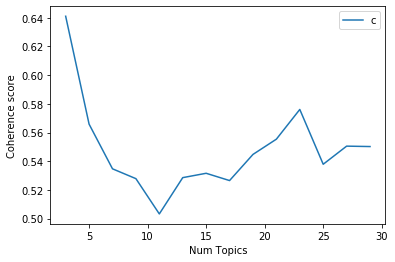

In [34]:
# Show graph
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [35]:
for m, cv in zip(x, coherence_values):
   print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.6411
Num Topics = 5  has Coherence Value of 0.5658
Num Topics = 7  has Coherence Value of 0.5347
Num Topics = 9  has Coherence Value of 0.5278
Num Topics = 11  has Coherence Value of 0.5032
Num Topics = 13  has Coherence Value of 0.5285
Num Topics = 15  has Coherence Value of 0.5316
Num Topics = 17  has Coherence Value of 0.5265
Num Topics = 19  has Coherence Value of 0.5447
Num Topics = 21  has Coherence Value of 0.5554
Num Topics = 23  has Coherence Value of 0.5761
Num Topics = 25  has Coherence Value of 0.5379
Num Topics = 27  has Coherence Value of 0.5505
Num Topics = 29  has Coherence Value of 0.5502


In [36]:
limit=30; start=3; step=3;

# Calculate model coherence with Nouns only
model_list_n, coherence_values_n = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=start, limit=limit, step=step
)



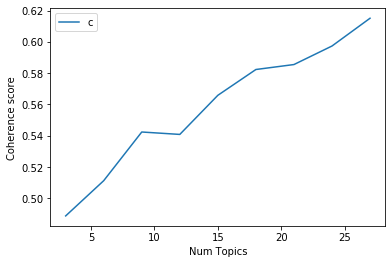

In [37]:
x = range(start, limit, step)
plt.plot(x, coherence_values_n)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [39]:
for m, cv in zip(x, coherence_values_n):
   print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 3  has Coherence Value of 0.4886
Num Topics = 6  has Coherence Value of 0.5112
Num Topics = 9  has Coherence Value of 0.5423
Num Topics = 12  has Coherence Value of 0.5408
Num Topics = 15  has Coherence Value of 0.5658
Num Topics = 18  has Coherence Value of 0.5823
Num Topics = 21  has Coherence Value of 0.5855
Num Topics = 24  has Coherence Value of 0.5973
Num Topics = 27  has Coherence Value of 0.6151


In [47]:
# Continue beyoin 30 topics: see if there is improvement

# Calculate model coherence with Nouns only
model_list_n2, coherence_values_n2 = coherence_values_computation (
   dictionary=id2word, corpus=corpus, texts=data_lemmatized, 
   start=30, limit=50, step=3
)

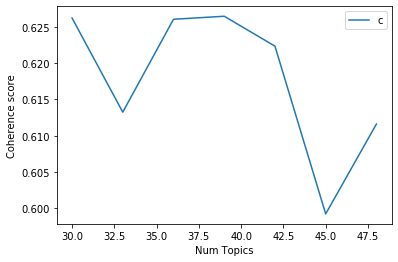

In [50]:
x = range(30, 50, 3)
plt.plot(x, coherence_values_n2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [51]:
for m, cv in zip(x, coherence_values_n2):
   print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 30  has Coherence Value of 0.6262
Num Topics = 33  has Coherence Value of 0.6133
Num Topics = 36  has Coherence Value of 0.626
Num Topics = 39  has Coherence Value of 0.6265
Num Topics = 42  has Coherence Value of 0.6223
Num Topics = 45  has Coherence Value of 0.5992
Num Topics = 48  has Coherence Value of 0.6116


# Selecting Number of Topics 

Nouns only:
Num Topics = 30  has Coherence Value of 0.6262

All Tags: 
Num Topics = 3  has Coherence Value of 0.6411

       

# Choose Number of Topics = 3 All Tags

In [44]:
lda_model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus_a, num_topics=3, id2word=id2word_a, random_seed=100,  topic_threshold=0)

coherence_model_lda = CoherenceModel(
   model=lda_model, texts=data_lemmatized_all, dictionary=id2word_a, coherence='c_v'
)
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)

lda_model.show_topics()


Coherence Score:  0.6312424077589612


[(0,
  '0.024*"measure" + 0.014*"continue" + 0.014*"activity" + 0.014*"home" + 0.012*"phase" + 0.011*"day" + 0.010*"service" + 0.010*"place" + 0.010*"senior" + 0.010*"risk"'),
 (1,
  '0.122*"infection" + 0.088*"confirm" + 0.078*"case" + 0.048*"detail" + 0.044*"discharge" + 0.039*"additional" + 0.038*"care" + 0.034*"highlight" + 0.032*"release" + 0.031*"press"'),
 (2,
  '0.174*"case" + 0.072*"work" + 0.063*"hospital" + 0.061*"community" + 0.046*"holder" + 0.038*"dormitory" + 0.036*"facility" + 0.033*"reside" + 0.032*"permit" + 0.028*"link"')]

In [46]:
for topic_id in range(lda_model.num_topics):
    topk = lda_model.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id +1, '|'.join(topk_words))) # Add 1 to topic id so our export matches the Intertopic Distance Map

1: measure|continue|activity|home|phase|day|service|place|risk|senior|transmission|patient|test|remain|resume|week|worker|stay|time|part|situation|health|local|family|visit|medical|circuit_breaker|virus|include|support
2: infection|confirm|case|detail|discharge|additional|care|highlight|release|press|condition|stable|critical|improve|unit|intensive|fully_recovered|moh|verified|read|news|www|update|pm|previous|base|issued_tonight|cluster|today|verify
3: case|work|hospital|community|holder|dormitory|facility|reside|permit|link|contact|resident|singaporean|permanent|pass|isolation|import|discharge|trace|follow|pende|known_cluster|breakdown|rest|preliminarily|investigation|d_of|establish|underway|tracing


The λ slider allows to rank the terms according to term relevance. By default, the terms of a topic are ranked in decreasing order according their topic-specific probability ( λ = 1 ). Moving the slider allows to adjust the rank of terms based on much discriminatory (or "relevant") are for the specific topic. The suggested “optimal” value of λ is 0.6.

Each bubble on the left-hand side plot represents a topic. The larger the bubble, the more prevalent is that topic.

A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one quadrant.

A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
from https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/
    

In [53]:
# from TutorialsPoint
#https://www.tutorialspoint.com/gensim/gensim_creating_lda_topic_model.htm
    
### Instal pip install pyLDAvis

####  Not working with Mallet model  #####

import pyLDAvis
import pyLDAvis.gensim

#pyLDAvis.enable_notebook()
#vis = pyLDAvis.gensim.prepare(lda_model, corpus_a, id2word_a)
#vis


In [ ]:
# Choose Number of Topics = 30 Nouns only

In [54]:
ldamallet_n = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=30, id2word=id2word, random_seed=100)

coherence_model_mallet = CoherenceModel(
   model=ldamallet_n, texts=data_lemmatized, dictionary=id2word, coherence='c_v'
)
coherence_score_mallet_n = coherence_model_mallet.get_coherence()
print('\nCoherence Score Mallet Nouns: ', coherence_score_mallet_n)

ldamallet_n.show_topics()



Coherence Score Mallet Nouns:  0.6262183116068571


[(27,
  '0.408*"contact" + 0.216*"breakdown" + 0.178*"known_cluster" + 0.052*"singaporean" + 0.038*"tracing" + 0.021*"tracer" + 0.014*"exit" + 0.007*"system" + 0.007*"slowing" + 0.003*"flight"'),
 (20,
  '0.361*"care" + 0.224*"condition" + 0.180*"unit" + 0.075*"news" + 0.024*"d_we" + 0.016*"practise" + 0.012*"safeguard" + 0.012*"response" + 0.012*"cheongdo" + 0.004*"pcr"'),
 (10,
  '0.236*"holder" + 0.207*"resident" + 0.193*"pass" + 0.151*"work" + 0.121*"investigation" + 0.007*"medisave" + 0.007*"blood" + 0.007*"management" + 0.003*"call" + 0.003*"contributor"'),
 (17,
  '0.718*"case" + 0.082*"resident" + 0.024*"passes_d_c" + 0.012*"region" + 0.012*"distancing" + 0.012*"traveler" + 0.012*"crisis" + 0.008*"recent_travel_history" + 0.008*"close_contact" + 0.008*"isolate"'),
 (15,
  '0.267*"activity" + 0.174*"phase" + 0.140*"senior" + 0.051*"resume" + 0.034*"rate" + 0.030*"resumption" + 0.025*"move" + 0.021*"centric" + 0.017*"close_contact" + 0.017*"priority"'),
 (29,
  '0.427*"community"

In [55]:
for topic_id in range(ldamallet_n.num_topics):
    topk = ldamallet_n.show_topic(topic_id, 30)
    topk_words = [ w for w, _ in topk ]
    
    print('{}: {}'.format(topic_id +1, '|'.join(topk_words))) # Add 1 to topic id so our export matches the Intertopic Distance Map

1: case|d_of|site|contact|d_to|resource|avoid|emergence|spirit|citizen|tcm|bay|lh|sport|ministry|crest|wellbeing|influenza|level|client|bed|weekend|dialysis|ncov|mobilise|distance|senior|issue|line|data
2: service|home|support|staff|visit|healthcare|restriction|centre|household|visitor|swab|session|clinic|outlet|delivery|flu|management|stay|passport|hypertension|relaxation|nursing|vacation|dedication|officer|method|hub|presentation|outpatient|manufacturing
3: mask|interaction|individual|setting|workplace|business|event|practice|time|meeting|safeentry|visitor|office|employer|return|detail|check|area|premise|meal|strait|implementation|employee|equipment|thought|addition|strategy|provider|start|facility
4: transmission|risk|situation|virus|measure|fight|end|chain|reduce|border|order|assessment|monitor|ease|easing|temperature|minister|singapore|resurgence|sacrifice|spread|fulfil|disability|appointment|court|reaction|consumer|tireless|tackle|polyclinic
5: case|resurgence|morning|complicatio

# Final selection: Model with Nouns, 30 topics
    Coherence score is similar to model with 3 topics for all tags, but visual inspection confirms the breakdown into 30 topics
    might make more sense in selecting specific behaviors for later analysis

# Save Topics

Once Model is Selected, add topics to dataframe and save as CSV

In [56]:
# rest of Notebook code refers to lda_model variable. Let's just reassign it to the ldamallet_n model
lda_model = ldamallet_n


# Add all topic contributions to dataframe

In [57]:
# LDA corpus contains the topic pct ditributions per text
# Make sure all topics are present in all text rows

for i, row in enumerate(lda_model[corpus]):
    print (row)

[(0, 0.03174603174603174), (1, 0.02976190476190475), (2, 0.02976190476190475), (3, 0.02976190476190475), (4, 0.035714285714285705), (5, 0.03373015873015872), (6, 0.02976190476190475), (7, 0.02976190476190475), (8, 0.02976190476190475), (9, 0.04563492063492063), (10, 0.02976190476190475), (11, 0.03373015873015872), (12, 0.02976190476190475), (13, 0.03373015873015872), (14, 0.02976190476190475), (15, 0.03174603174603174), (16, 0.047619047619047616), (17, 0.03174603174603174), (18, 0.02976190476190475), (19, 0.02976190476190475), (20, 0.02976190476190475), (21, 0.02976190476190475), (22, 0.05952380952380952), (23, 0.03174603174603174), (24, 0.02976190476190475), (25, 0.02976190476190475), (26, 0.03373015873015872), (27, 0.02976190476190475), (28, 0.02976190476190475), (29, 0.04365079365079365)]
[(0, 0.05555555555555556), (1, 0.028735632183908035), (2, 0.028735632183908035), (3, 0.04597701149425287), (4, 0.03065134099616857), (5, 0.03065134099616857), (6, 0.028735632183908035), (7, 0.02873

In [58]:
dfAll_topics = pd.DataFrame()
new_corpus = lda_model[corpus]
for topic_id in range(lda_model.num_topics):
    str_topic_id = str(topic_id+1)
    #dfAll_topics['topic_' + str_topic_id] = pd.Series([a[topic_id][0] for a in lda_model[corpus]])
    dfAll_topics['topic_' + str_topic_id + '_pct'] = pd.Series([a[topic_id][1] for a in new_corpus])

In [59]:
dfAll_topics.head(5)

,topic_1_pct,topic_2_pct,topic_3_pct,topic_4_pct,topic_5_pct,topic_6_pct,topic_7_pct,topic_8_pct,topic_9_pct,topic_10_pct,...,topic_21_pct,topic_22_pct,topic_23_pct,topic_24_pct,topic_25_pct,topic_26_pct,topic_27_pct,topic_28_pct,topic_29_pct,topic_30_pct
0,0.031746,0.029762,0.029762,0.029762,0.035714,0.033730,0.029762,0.029762,0.029762,0.045635,...,0.029762,0.029762,0.059524,0.031746,0.029762,0.029762,0.033730,0.029762,0.029762,0.043651
1,0.055556,0.028736,0.028736,0.045977,0.030651,0.030651,0.028736,0.028736,0.030651,0.028736,...,0.028736,0.032567,0.045977,0.028736,0.028736,0.028736,0.028736,0.040230,0.028736,0.028736
2,0.030864,0.032922,0.030864,0.043210,0.032922,0.030864,0.030864,0.030864,0.030864,0.030864,...,0.030864,0.030864,0.030864,0.030864,0.043210,0.030864,0.047325,0.030864,0.034979,0.032922
3,0.034188,0.032051,0.032051,0.032051,0.036325,0.034188,0.032051,0.032051,0.034188,0.032051,...,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051
4,0.038462,0.032051,0.032051,0.032051,0.044872,0.034188,0.032051,0.032051,0.040598,0.032051,...,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051


# Find Dominant Topic

In [60]:
dfDominant = pd.DataFrame()
for i, row in enumerate(lda_model[corpus]):
    row = sorted(row, key=lambda x: (x[1]), reverse=True) # sort topics to obtain highest score
    #print(row)
    for j, (topic_num, prop_topic) in enumerate(row):
        if j == 0: #  dominant topic, after sorting by contribution
            wp = lda_model.show_topic(topic_num)
            dom_topic = topic_num + 1 # again, add 1 so topic numbers match Intertopic Distance Map
            #print(wp)
            topic_keywords = "| ".join([word for word, prop in wp])
            #print(topic_keywords)
            dfDominant = dfDominant.append( pd.Series([dom_topic, prop_topic, topic_keywords]), ignore_index=True)
        else:
            break
dfDominant.columns = ['Dominant_Topic', 'Dominant_Pct', 'Dominant_Topic_Keywords']

In [61]:
dfDominant.Dominant_Topic = dfDominant.Dominant_Topic.astype(int)
dfDominant.head(5)

,Dominant_Topic,Dominant_Pct,Dominant_Topic_Keywords
0,23,0.059524,time| group| person| student| face| video| con...
1,17,0.063218,day| place| shn| travel| country| hour| travel...
2,15,0.049383,infection| patient| evidence| plan| approach| ...
3,13,0.042735,infection| fence| role| outbreak| recovery| br...
4,5,0.044872,case| morning| resurgence| lockdown| conduct| ...


In [62]:
dfDominant.groupby('Dominant_Topic').count()

,Dominant_Pct,Dominant_Topic_Keywords
Dominant_Topic,,
1,29,29
2,46,46
3,35,35
4,51,51
5,17,17
6,9,9
7,48,48
8,40,40
9,20,20


# Add Topic Scores to Data Frame

In [47]:
#dfPosts.head()

In [63]:
dfClassified = dfPosts.copy()
dfClassified = dfClassified.join(dfDominant)
dfClassified = dfClassified.join(dfAll_topics)

In [64]:
dfClassified.head(5)

,Source,Date,Post_id,Sentence_id,Text,Shares,Likes,Comments,Dominant_Topic,Dominant_Pct,...,topic_21_pct,topic_22_pct,topic_23_pct,topic_24_pct,topic_25_pct,topic_26_pct,topic_27_pct,topic_28_pct,topic_29_pct,topic_30_pct
0,1,2020-02-01,0,1,update on the 2019 novel coronavirus (ncov) - ...,52,54,4,23,0.059524,...,0.029762,0.029762,0.059524,0.031746,0.029762,0.029762,0.033730,0.029762,0.029762,0.043651
1,1,2020-02-01,0,2,there is no need to avoid places where persons...,52,54,4,17,0.063218,...,0.028736,0.032567,0.045977,0.028736,0.028736,0.028736,0.028736,0.040230,0.028736,0.028736
2,1,2020-02-01,0,3,there is also currently no evidence of communi...,52,54,4,15,0.049383,...,0.030864,0.030864,0.030864,0.030864,0.043210,0.030864,0.047325,0.030864,0.034979,0.032922
3,1,2020-02-01,1,1,as of 1 february 2020 2pm we have confirmed 2 ...,151,122,14,13,0.042735,...,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051
4,1,2020-02-01,1,2,16 confirmed cases were earlier announced by m...,151,122,14,5,0.044872,...,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051,0.032051


# Save the classified dataframe to CSV

In [65]:
#output_file_name = "Twitter_with_topics.csv"
output_file_name = "Facebook_sentences_mallet_30_topics.csv"

dfClassified.to_csv(output_file_name)